In [48]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import numpy as np


In [49]:
X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [50]:
pipeline = Pipeline(
    [
        ("imputer", StandardScaler()),
        ("classifier", SVC(random_state=42, probability=True)),
    ]
)

In [51]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "classifier__kernel": ["linear", "rbf", "poly"],
    "classifier__C": [0.1, 1, 10, 100],
    "classifier__gamma": ["scale", "auto", 0.01, 0.1],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
    cv=skf,
)

grid_search.fit(X_train, y_train)

print(f"Meilleurs parametres : {grid_search.best_params_}")
print(f"Meilleur score CV : {grid_search.best_score_}")

Meilleurs parametres : {'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
Meilleur score CV : 0.9738878509919948


In [52]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Rapport de classification")
print(classification_report(y_test, y_pred))

Rapport de classification
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



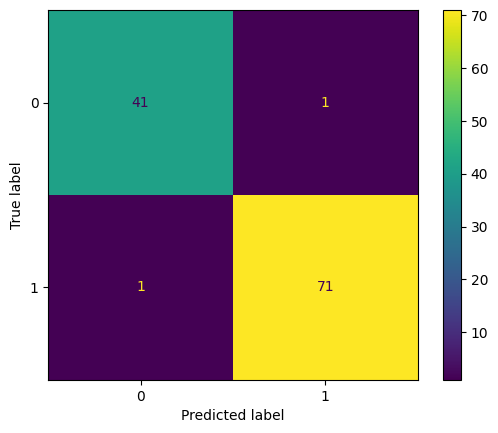

In [53]:
conf_mat = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_mat).plot()

In [54]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

print(f"AUC : {auc}")

AUC : 0.9976851851851851


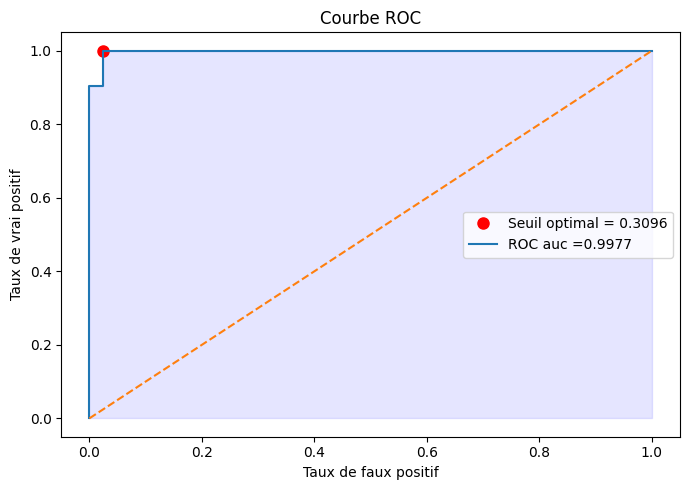

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

axes.plot(
    fpr[optimal_idx],
    tpr[optimal_idx],
    "ro",
    markersize=8,
    label=f"Seuil optimal = {optimal_threshold:.4f}",
)

axes.plot(fpr, tpr, label=f"ROC auc ={auc:.4f}")
axes.plot([0, 1], [0, 1], "--")
axes.fill_between(fpr, tpr, alpha=0.1, color="blue")

axes.set_title("Courbe ROC")
axes.set_xlabel("Taux de faux positif")
axes.set_ylabel("Taux de vrai positif")
axes.legend()

plt.tight_layout()
plt.show()